# Setup

In [93]:
import time
import tenseal as ts

POLY_MODULUS_DEGREE = 4096 * 2
#POLY_MODULUS_DEGREE = 16384
# Setup TenSEAL context
context = ts.context(
    ts.SCHEME_TYPE.BFV,
    poly_modulus_degree=POLY_MODULUS_DEGREE,
    plain_modulus=536903681
)
context.generate_galois_keys()

In [94]:
# Helper functions
def encrypt_value(value):
    encrypted_value = ts.bfv_vector(context, [value])
    return encrypted_value

def decrypt_value(encrypted_value):
    decrypted_value = encrypted_value.decrypt()
    return decrypted_value[0]

In [95]:
vector = [i for i in range(4096)]
encrypted_vector = ts.bfv_vector(context, vector)
serialized = encrypted_vector.serialize()
size = len(serialized)
size_per_element = size/1000
print(f"Size of the encrypted vecotor: {size/8/1024} KB")
print(f"Size per element: {size_per_element} bytes")


Size of the encrypted vecotor: 52.7933349609375 KB
Size per element: 432.483 bytes


# Computation

In [96]:
def calculate_encrypted_sum_single(vector):
    encrypted_sum = encrypt_value(0)
    for value in vector:
        encrypted_value = encrypt_value(value)
        encrypted_sum += encrypted_value
    return encrypted_sum

vector = [i for i in range(10)]
encrypted_sum = calculate_encrypted_sum_single(vector)
decrypted_sum = decrypt_value(encrypted_sum)
print(f"Encrypted sum: {decrypted_sum}")

Encrypted sum: 45


In [97]:
def calculate_encrypted_sum(vector):
    """
    This function works for vectors of any size
    :param vector:
    :return:
    """
    encrypted_vector = ts.bfv_vector(context, vector)
    encrypted_sum = encrypted_vector.sum()
    return encrypted_sum

In [98]:
import time

NUMBER_OF_ELEMENTS = 1750

vector = [i for i in range(NUMBER_OF_ELEMENTS)]
print(f"Vectorsum: {sum(vector)}")
start = time.perf_counter_ns()

encrypted_vector = ts.bfv_vector(context, vector)
encrypted_sum = encrypted_vector.sum()

decrypted_sum = encrypted_sum.decrypt()

stop = time.perf_counter_ns()
print(f"Time: {(stop-start)/1e6} ms")

decrypted_sum

Vectorsum: 1530375
Time: 122.5307 ms


[1530375]

In [99]:
# Test the same performance with a same size vector using numpy
import numpy as np

vector = np.arange(NUMBER_OF_ELEMENTS)
start = time.perf_counter_ns()
sum_vector = np.sum(vector)
stop = time.perf_counter_ns()
print(f"Time: {(stop-start)/1e6} ms")
sum_vector



Time: 0.0772 ms


1530375

In [108]:
# test the performance of the encryption vs the numpy sum
# go from 100 to 100000 elements
# plot the time taken for each
import matplotlib.pyplot as plt

times_numpy = []
times_tenseal = []
times_tenseal_single = []
times_tenseal_encrypt = []
times_tenseal_decrypt = []

START = 100
NUMBER_OF_ELEMENTS = 2100
STEPS = 100

for i in range(START, NUMBER_OF_ELEMENTS, STEPS):
    print(f"Calculating for {i} elements")
    vector = np.arange(i)
    times_temp = []
    for j in range(1000):
        
        start = time.perf_counter_ns()
        sum_vector = np.sum(vector)
        stop = time.perf_counter_ns()
        times_temp.append((stop-start)/1e6)
    times_numpy.append(sum(times_temp)/len(times_temp))
    
    #print(f"Done with numpy")
    
    times_temp.clear()
    times_temp_encrypt = []
    times_temp_decrypt = []
    for j in range(100):
        start = time.perf_counter_ns()
        encrypted_vector = ts.bfv_vector(context, vector)
        times_temp_encrypt.append((time.perf_counter_ns()-start)/1e6)
        
        # Sum the encrypted vector elements
        start = time.perf_counter_ns()
        encrypted_sum = encrypted_vector.sum()
        times_temp.append((time.perf_counter_ns()-start)/1e6)
        
        # Decrypt the sum
        start = time.perf_counter_ns()
        decrypted_sum = encrypted_sum.decrypt()
        times_temp_decrypt.append((time.perf_counter_ns()-start)/1e6)
    
    # times_tenseal.append(sum(times_temp)/len(times_temp))
    # times_tenseal_encrypt.append(sum(times_temp_encrypt)/len(times_temp_encrypt))
    # times_tenseal_decrypt.append(sum(times_temp_decrypt)/len(times_temp_decrypt))
    
    # use median instead of mean
    times_tenseal.append(np.median(times_temp))
    times_tenseal_encrypt.append(np.median(times_temp_encrypt))
    times_tenseal_decrypt.append(np.median(times_temp_decrypt))
    
    # print(f"Done with tenseal")
    """
    times_temp.clear()
    for j in range(100):
        start = time.perf_counter_ns()
        encrypted_sum = calculate_encrypted_sum_single(vector)
        decrypted_sum = decrypt_value(encrypted_sum)
        stop = time.perf_counter_ns()
        times_temp.append((stop-start)/1e6)
    times_tenseal_single.append(sum(times_temp)/len(times_temp))
    
    print(f"Done with tenseal single")
    
    print(f"Done with {i} elements")
    """


Calculating for 100 elements
Calculating for 200 elements
Calculating for 300 elements
Calculating for 400 elements
Calculating for 500 elements
Calculating for 600 elements
Calculating for 700 elements
Calculating for 800 elements
Calculating for 900 elements
Calculating for 1000 elements
Calculating for 1100 elements
Calculating for 1200 elements
Calculating for 1300 elements
Calculating for 1400 elements
Calculating for 1500 elements
Calculating for 1600 elements
Calculating for 1700 elements
Calculating for 1800 elements
Calculating for 1900 elements
Calculating for 2000 elements


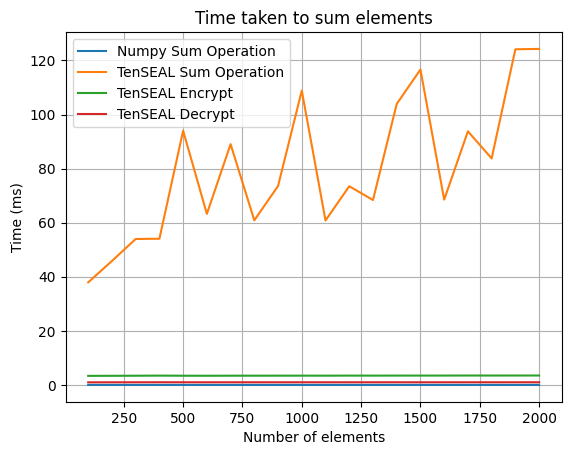

In [111]:
START = 100
NUMBER_OF_ELEMENTS = 2100
STEPS = 100

plt.figure()
# enable the grid
plt.grid(True)
plt.xlabel("Number of elements")
plt.ylabel("Time (ms)")
plt.title("Time taken to sum elements")



plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), times_numpy, label="Numpy Sum Operation")
plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), times_tenseal, label="TenSEAL Sum Operation")
plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), times_tenseal_encrypt, label="TenSEAL Encrypt")
plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), times_tenseal_decrypt, label="TenSEAL Decrypt")
# plt.plot(range(100, NUMBER_OF_ELEMENTS, STEPS), times_tenseal_single, label="TenSEAL Single")

# enable legend
plt.legend()

# Time difference between numpy and tenseal

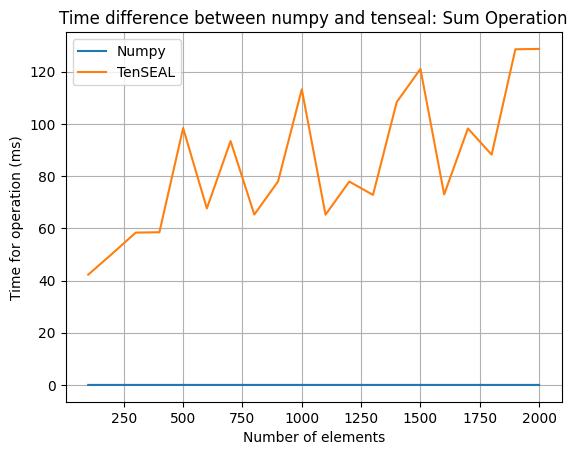

In [112]:
# only plot the time difference between numpy and tenseal and not the single sum

plt.figure()
# enable the grid
plt.grid(True)
plt.xlabel("Number of elements")
plt.ylabel("Time for operation (ms)")
plt.title("Time difference between numpy and tenseal: Sum Operation")
times_tenseal_sum = [tenseal + tenseal_decrypt + tenseal_encrypt for tenseal, tenseal_decrypt, tenseal_encrypt in zip(times_tenseal, times_tenseal_decrypt, times_tenseal_encrypt)]

#plt.plot(range(100, NUMBER_OF_ELEMENTS, STEPS), time_diff, label="Numpy - TenSEAL")
plt.plot(range(100, NUMBER_OF_ELEMENTS, STEPS), times_numpy, label="Numpy")
plt.plot(range(100, NUMBER_OF_ELEMENTS, STEPS), times_tenseal_sum, label="TenSEAL")
plt.legend()

In [113]:
# calculate the average time difference

time_diff = [numpy - tenseal for numpy, tenseal in zip(times_numpy, times_tenseal_sum)]
avg_diff = abs(sum(time_diff) / len(time_diff))
print(f"Average time difference: {avg_diff} ms")

Average time difference: 84.37675095 ms


# Calculate bigger encrpyted Vectors by splitting them in equal chunks

- split the vector into smaller chunks
- encrypt the chunks
- sum the chunks
- sum the sums

In [114]:
def calculate_encrypted_sum_multiple(vector):
    """
    This functions doesn't work! cant compute on vectors of different sizes

    if the vector is too large, we can split it into smaller chunks
    and sum the chunks
    :param vector:
    :return:
    """
    divisor = int(POLY_MODULUS_DEGREE / 2) # this is the maximum size of the vector that can be encrypted
    #if len(vector) % divisor != 0:
    #    raise ValueError("The vector size must be a multiple of the divisor")

    sums = []
    if len(vector) > divisor:
        for i in range(0, len(vector), divisor):
            chunk = vector[i:i+divisor]
            encrypted_chunk = ts.bfv_vector(context, chunk)
            encrypted_sum = encrypted_chunk.sum()
            sums.append(encrypted_sum)
    else:
        encrypted_vector = ts.bfv_vector(context, vector)
        encrypted_sum = encrypted_vector.sum()
        sums.append(encrypted_sum)
    
    # print(f"Number of blocks: {len(sums)}")

    encrypted_sum = sums[0]
    for s in sums[1:]:
        encrypted_sum += s

    decrypted_sum = encrypted_sum.decrypt()
    return decrypted_sum


vector = [1 for i in range(1700)]
s = sum(vector)
vector_sum = calculate_encrypted_sum_multiple(vector)
print(f"Encrypted sum: {vector_sum} / {sum(vector)}")

Encrypted sum: [1700] / 1700


In [115]:
def encrypt_vector_for_sum(vector: list) -> (list, int):
    """
    Encrypt the vector, if the vector is too large, we can split it into smaller chunks and return the encrypted chunks
    and number of chunks
    :Note: This only works for sum operations because the resulting vectors can be of different sizes
    :param vector:
    :return:
    """
    divisor = int(POLY_MODULUS_DEGREE / 2)  # the divisor splits the vector into smaller chunks to be encrypted,
    encrypted_chunks = []
    if len(vector) > divisor:
        for i in range(0, len(vector), divisor):
            chunk = vector[i:i + divisor]
            encrypted_chunk = ts.bfv_vector(context, chunk)
            encrypted_chunks.append(encrypted_chunk)
    else:
        encrypted_vector = ts.bfv_vector(context, vector)
        encrypted_chunks.append(encrypted_vector)

    return encrypted_chunks, len(vector)


def sum_encrypted_vector(encrypted_vectors: list[ts.bfv_vector]) -> ts.bfv_vector:
    encrypted_sum = encrypted_vectors[0].sum()
    for s in encrypted_vectors[1:]:
        encrypted_sum += s.sum()
    return encrypted_sum



In [116]:
vector = [1 for i in range(10000)]
encrypted_chunks, num_elements = encrypt_vector_for_sum(vector)
encrypted_sum = sum_encrypted_vector(encrypted_chunks)
decrypted_sum = encrypted_sum.decrypt()
print(f"Encrypted sum: {decrypted_sum} Expected: {sum(vector)}")

Encrypted sum: [10000] Expected: 10000


In [118]:
import matplotlib.pyplot as plt

times_numpy = []
times_tenseal = []
times_tenseal_encrypt = []
times_tenseal_decrypt = []

START = 2000
NUMBER_OF_ELEMENTS = 20000
STEPS = 2000

for i in range(START, NUMBER_OF_ELEMENTS, STEPS):
    vector = [1 for i in range(i)]
    arr = np.ones(i)
    
    times_temp = []
    for j in range(1000):
        start = time.perf_counter_ns()
        sum_vector = np.sum(arr)
        stop = time.perf_counter_ns()
        times_temp.append((stop-start)/1e6)
    times_numpy.append(sum(times_temp)/len(times_temp))
    
    times_temp.clear()
    times_temp_encrypt = []
    times_temp_decrypt = []
    for j in range(100):
        start = time.perf_counter_ns()
        encrypted_chunks, _ = encrypt_vector_for_sum(vector)
        times_temp_encrypt.append((time.perf_counter_ns()-start)/1e6)
        
        start = time.perf_counter_ns()
        encrypted_sum = sum_encrypted_vector(encrypted_chunks)
        times_temp.append((time.perf_counter_ns()-start)/1e6)
        
        start = time.perf_counter_ns()
        decrypted_sum = encrypted_sum.decrypt()
        times_temp_decrypt.append((time.perf_counter_ns()-start)/1e6)
        
    
    # times_tenseal.append(sum(times_temp)/len(times_temp))
    # times_tenseal_encrypt.append(sum(times_temp_encrypt)/len(times_temp_encrypt))
    # times_tenseal_decrypt.append(sum(times_temp_decrypt)/len(times_temp_decrypt))
    # use median instead of mean
    times_tenseal.append(np.median(times_temp))
    times_tenseal_encrypt.append(np.median(times_temp_encrypt))
    times_tenseal_decrypt.append(np.median(times_temp_decrypt))
    
    print(f"Done with {i} elements")


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (9,) and (1,)

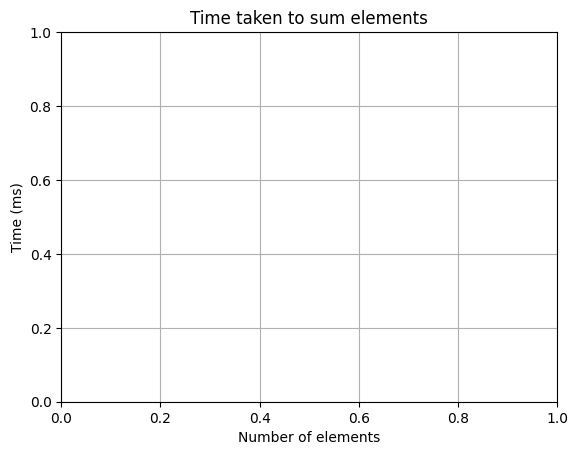

In [119]:
# plot the time difference between numpy and tenseal
plt.figure()
# enable the grid
plt.grid(True)
plt.xlabel("Number of elements")
plt.ylabel("Time (ms)")
plt.title("Time taken to sum elements")


plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), times_numpy, label="Numpy Sum Operation")
plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), times_tenseal, label="TenSEAL Sum Operation")
plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), times_tenseal_encrypt, label="TenSEAL Encrypt")
plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), times_tenseal_decrypt, label="TenSEAL Decrypt")

# enable legend
plt.legend()

In [120]:
times_tenseal_sum = [tenseal + tenseal_decrypt + tenseal_encrypt for tenseal, tenseal_decrypt, tenseal_encrypt in zip(times_tenseal, times_tenseal_decrypt, times_tenseal_encrypt)]
print(f"Time numpy                 min: {min(times_numpy)} max: {max(times_numpy)}")
print(f"Time tenseal sum operation min: {min(times_tenseal)} max: {max(times_tenseal)}")
print(f"Time tenseal encrypt       min: {min(times_tenseal_encrypt)} max: {max(times_tenseal_encrypt)}")
print(f"Time max tenseal decrypt   min: {min(times_tenseal_decrypt)} max: {max(times_tenseal_decrypt)}")
print(f"Time max tenseal total     min {min(times_tenseal_sum)} max: {max(times_tenseal_sum)}")
times_numpy_avg = sum(times_numpy)/len(times_numpy)
print(f"max factor: {times_tenseal_sum[-1]/times_numpy_avg}")

Time numpy                 min: 0.003205799999999975 max: 0.003205799999999975


ValueError: min() arg is an empty sequence

In [ ]:
# plot the time difference between numpy and tenseal
plt.figure()
# enable the grid
plt.grid(True)
plt.xlabel("Number of elements")
plt.ylabel("Time difference in percent")
plt.title("Time difference between numpy and tenseal")

time_diff = [tenseal - numpy for numpy, tenseal in zip(times_numpy, times_tenseal_sum)]
plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), time_diff, label="Numpy - TenSEAL")
plt.legend()

In [ ]:
# linear regression to draw a line through the data
from sklearn.linear_model import LinearRegression

X = np.array(range(START, NUMBER_OF_ELEMENTS, STEPS)).reshape(-1, 1)

reg = LinearRegression().fit(X, time_diff)
reg.score(X, time_diff)

plt.figure()
# enable the grid
plt.grid(True)
plt.xlabel("Number of elements")
plt.ylabel("Time difference in factors")
plt.title("Time difference between numpy and tenseal")
plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), time_diff, label="Numpy - TenSEAL")
plt.plot(X, reg.predict(X), label="Linear regression")
plt.legend()

In [ ]:
# plot the time difference between numpy and tenseal
plt.figure()
# enable the grid
plt.grid(True)
plt.xlabel("Number of elements")
plt.ylabel("Time difference (ms)")
plt.title("Time difference between numpy and tenseal")
z = list(zip(times_numpy, times_tenseal))
time_diff = [tenseal - numpy for numpy, tenseal in zip(times_numpy, times_tenseal)]
plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), time_diff, label="Numpy - TenSEAL")
plt.legend()



# Size Difference of plain vs encrypted data

In [136]:
import base64

def encrypt_vector_batching(context, vector: list) -> (list, int):
    """
    Encrypt the vector, if the vector is too large, we can split it into smaller chunks and return the encrypted chunks
    and number of chunks
    :Note: This only works for sum operations because the resulting vectors can be of different sizes
    :param vector:
    :return:
    """
    divisor = int(POLY_MODULUS_DEGREE / 2)  # the divisor splits the vector into smaller chunks to be encrypted,
    encrypted_chunks = []
    if len(vector) > divisor:
        for i in range(0, len(vector), divisor):
            chunk = vector[i:i + divisor]
            encrypted_chunk = ts.bfv_vector(context, chunk)
            encrypted_chunks.append(encrypted_chunk)
    else:
        encrypted_vector = ts.bfv_vector(context, vector)
        encrypted_chunks.append(encrypted_vector)

    return encrypted_chunks, len(vector)


def sum_encrypted_vector(encrypted_vectors: list[ts.bfv_vector]) -> ts.bfv_vector:
    encrypted_sum = encrypted_vectors[0].sum()
    for s in encrypted_vectors[1:]:
        encrypted_sum += s.sum()
    return encrypted_sum


def serialize_encrypted_vector(encrypted_vectors: ts.bfv_vector) -> str:
    """
    Serialize the encrypted vector to bytes and then to base64
    :param encrypted_vectors: encrypted vector
    :return: serialized encrypted vector
    """
    bytes = encrypted_vectors.serialize()
    serialized = base64.b64encode(bytes)
    string_data = serialized.decode('utf-8')
    return string_data


def serialize_encrypted_vectors(encrypted_vectors: list[ts.bfv_vector]) -> list[str]:
    """
    Serialize the encrypted vectors to bytes and then to base64
    :param encrypted_vectors: list of encrypted vectors
    :return: list of serialized encrypted vectors
    """
    serialized_vectors = []
    for v in encrypted_vectors:
        serialized = serialize_encrypted_vector(v)
        serialized_vectors.append(serialized)
    return serialized_vectors


def get_serialized_context(context):
    context_serialized = context.serialize(save_public_key=True, save_secret_key=False, save_galois_keys=True)
    context_encoded = base64.b64encode(context_serialized).decode('utf-8')
    return context_encoded


In [140]:
arr = np.ones(100)
vector = [1 for i in range(100)]

encrypted_vectors, num_elements = encrypt_vector_batching(context, vector)
serialized_vectors = serialize_encrypted_vectors(encrypted_vectors)
size_phe = sum([len(s.encode('utf-8')) for s in serialized_vectors])

print(f"Size of plain vector: {arr.nbytes/1024} KB")
print(f"Size of the encrypted vecotor: {size_phe/1024} KB")
print(f"Size of context: {len(get_serialized_context(context).encode('utf-8'))/1024/1024} MB")

Size of plain vector: 0.78125 KB
Size of the encrypted vecotor: 563.15625 KB
Size of context: 69.64385604858398 MB


In [143]:
import matplotlib.pyplot as plt

sizes_plain = []
sizes_encrypted = []

START = 10000
NUMBER_OF_ELEMENTS = 500000
STEPS = 10000
print("Calculating sizes")
for i in range(START, NUMBER_OF_ELEMENTS, STEPS):
    print(f"Calculating for {i} elements")
    vector = [1 for i in range(i)]
    arr = np.ones(i)

    start = time.perf_counter_ns()
    size = arr.nbytes
    size_kb = size/1024
    size_mb = size_kb/1024
    stop = time.perf_counter_ns()
    sizes_plain.append(size_mb)

    #print(f"Done with numpy")

    start = time.perf_counter_ns()
    
    encrypted_vectors, num_elements = encrypt_vector_batching(context, vector)
    serialized_vectors = serialize_encrypted_vectors(encrypted_vectors)
    size = sum([len(s.encode('utf-8')) for s in serialized_vectors])
    size_kb = size/1024
    size_mb = size_kb/1024
    stop = time.perf_counter_ns()
    sizes_encrypted.append(size_mb)
    #print(f"Done with {i} elements")




Calculating sizes
Calculating for 10000 elements
Calculating for 20000 elements
Calculating for 30000 elements
Calculating for 40000 elements
Calculating for 50000 elements
Calculating for 60000 elements
Calculating for 70000 elements
Calculating for 80000 elements
Calculating for 90000 elements
Calculating for 100000 elements
Calculating for 110000 elements
Calculating for 120000 elements
Calculating for 130000 elements
Calculating for 140000 elements
Calculating for 150000 elements
Calculating for 160000 elements
Calculating for 170000 elements
Calculating for 180000 elements
Calculating for 190000 elements
Calculating for 200000 elements
Calculating for 210000 elements
Calculating for 220000 elements
Calculating for 230000 elements
Calculating for 240000 elements
Calculating for 250000 elements
Calculating for 260000 elements
Calculating for 270000 elements
Calculating for 280000 elements
Calculating for 290000 elements
Calculating for 300000 elements
Calculating for 310000 elements

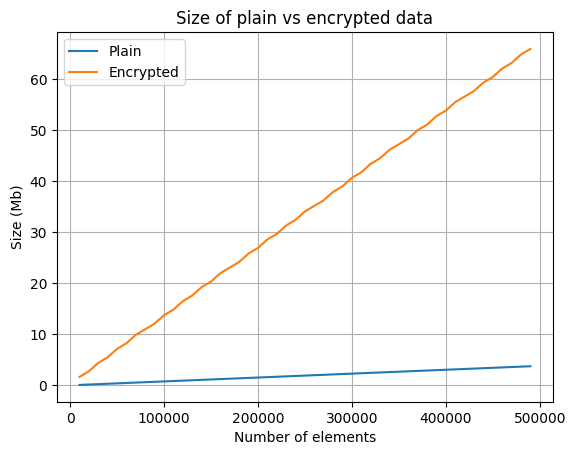

In [144]:
plt.figure()
# enable the grid
plt.grid(True)
plt.xlabel("Number of elements")
plt.ylabel("Size (Mb)")
plt.title("Size of plain vs encrypted data")

plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), sizes_plain, label="Plain")
plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), sizes_encrypted, label="Encrypted")

# enable legend
plt.legend()

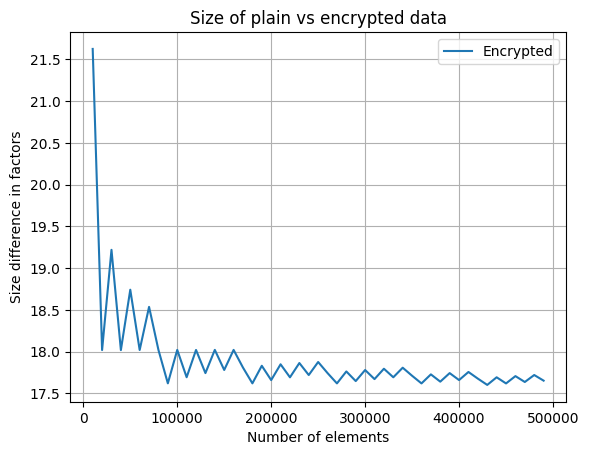

In [146]:
plt.figure()
# enable the grid
plt.grid(True)
plt.xlabel("Number of elements")
plt.ylabel("Size difference in factors")
plt.title("Size of plain vs encrypted data")

size_diff = [encrypted / plain for plain, encrypted in zip(sizes_plain, sizes_encrypted)]

plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), size_diff, label="Encrypted")

# enable legend
plt.legend()

# Bigger Poly Modulus Degree

In [172]:
import matplotlib.pyplot as plt

sizes_plain = []
sizes_encrypted = {}

START = 10000
NUMBER_OF_ELEMENTS = 500000
STEPS = 10000
print("Calculating sizes")

for i in range(START, NUMBER_OF_ELEMENTS, STEPS):
    print(f"Calculating for {i} elements")
    arr = np.ones(i)
    size = arr.nbytes
    size_kb = size/1024
    size_mb = size_kb/1024
    sizes_plain.append(size_mb)
    

for poly in [4096, 8192, 16384]:
    print(f"Calculating for poly: {poly}")
    POLY_MODULUS_DEGREE = poly
    context = ts.context(
        ts.SCHEME_TYPE.BFV,
        poly_modulus_degree=POLY_MODULUS_DEGREE,
        plain_modulus=536903681
    )
    context.generate_galois_keys()
    for i in range(START, NUMBER_OF_ELEMENTS, STEPS):
        print(f"Calculating for {i} elements")
        vector = [1 for i in range(i)]
        encrypted_vectors, num_elements = encrypt_vector_batching(context, vector)
        serialized_vectors = serialize_encrypted_vectors(encrypted_vectors)
        size = sum([len(s.encode('utf-8')) for s in serialized_vectors])

        size_kb = size/1024
        size_mb = size_kb/1024

        
        #sizes_encrypted.setdefault(poly, []).append(size_mb)
        if poly not in sizes_encrypted:
            sizes_encrypted[poly] = []
        sizes_encrypted[poly].append(size_mb)
    
    #print(f"Done with {i} elements")


Calculating sizes
Calculating for 10000 elements
Calculating for 20000 elements
Calculating for 30000 elements
Calculating for 40000 elements
Calculating for 50000 elements
Calculating for 60000 elements
Calculating for 70000 elements
Calculating for 80000 elements
Calculating for 90000 elements
Calculating for 100000 elements
Calculating for 110000 elements
Calculating for 120000 elements
Calculating for 130000 elements
Calculating for 140000 elements
Calculating for 150000 elements
Calculating for 160000 elements
Calculating for 170000 elements
Calculating for 180000 elements
Calculating for 190000 elements
Calculating for 200000 elements
Calculating for 210000 elements
Calculating for 220000 elements
Calculating for 230000 elements
Calculating for 240000 elements
Calculating for 250000 elements
Calculating for 260000 elements
Calculating for 270000 elements
Calculating for 280000 elements
Calculating for 290000 elements
Calculating for 300000 elements
Calculating for 310000 elements

START: 10000 NUMBER_OF_ELEMENTS: 500000 STEPS: 10000
Poly: 4096
len: 49
Poly: 8192
len: 49
Poly: 16384
len: 49


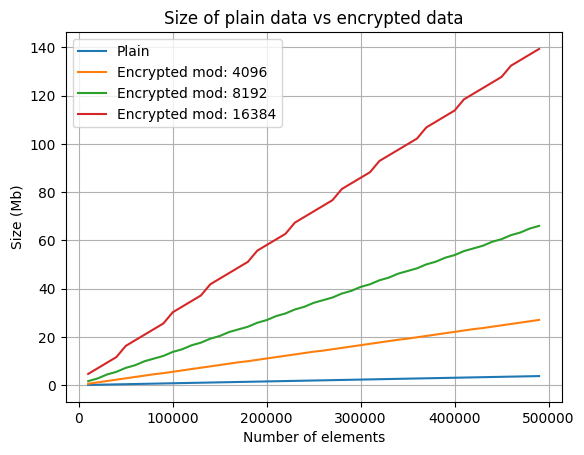

In [174]:

plt.figure()
# enable the grid
plt.grid(True)
plt.xlabel("Number of elements")
plt.ylabel("Size (Mb)")
plt.title("Size of plain data vs encrypted data")

print(f"START: {START} NUMBER_OF_ELEMENTS: {NUMBER_OF_ELEMENTS} STEPS: {STEPS}")

plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), sizes_plain, label="Plain")

for poly, sizes in sizes_encrypted.items():
    print(f"Poly: {poly}")
    print(f"len: {len(sizes)}")
    plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), sizes, label=f"Encrypted mod: {poly}")
#plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), sizes_encrypted, label="Encrypted")

# enable legend
plt.legend()

# Context Size  

In [175]:
for poly in [4096, 8192, 16384]:
    print(f"Calculating for poly: {poly}")
    POLY_MODULUS_DEGREE = poly
    context = ts.context(
        ts.SCHEME_TYPE.BFV,
        poly_modulus_degree=POLY_MODULUS_DEGREE,
        plain_modulus=536903681
    )
    context.generate_galois_keys()
    context_bytes_size = len(get_serialized_context(context).encode('utf-8'))
    print(f"Size of context: {context_bytes_size/1024/1024} MB")


Calculating for poly: 4096
Size of context: 8.240764617919922 MB
Calculating for poly: 8192
Size of context: 69.64550018310547 MB
Calculating for poly: 16384
Size of context: 567.8547782897949 MB
